# CS4248 Project - Labelled Unreliable News (LUN)

## Imports

In [32]:
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
import gensim

from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from textblob import TextBlob
from readability import Readability

import warnings
warnings.filterwarnings('ignore')

In [33]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}

stop_words = set(stopwords.words('english'))
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stemmer = None
# lemmatizer = None

TEST_SIZE = 0.1
SMOOTHING = 1.0
NGRAM_RANGE = (1, 1)

## Helper Functions

In [34]:
def preprocess(sentence, lower_case=True, remove_punctuation=True, replace_contractions=True):
    if lower_case:
        sentence = sentence.lower()
    if remove_punctuation:
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    if replace_contractions:
        news = sentence.split()
        new_news = []
        for word in news:
            if word in contractions:
                new_news.append(contractions[word])
            else:
                new_news.append(word)
        sentence = " ".join(new_news)
    return sentence

In [35]:
def tokenize(sentence, stemmer=stemmer, lemmatizer=lemmatizer, remove_stop_words=False):
    tokens = word_tokenize(sentence)
    
    if remove_stop_words:
        tokens = [token for token in tokens if token not in stop_words]
    if stemmer:
        tokens = [stemmer.stem(token) for token in tokens]
    if lemmatizer:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
    return tokens

## Load Data

In [36]:
full_train_df = pd.read_csv('raw_data/fulltrain.csv', header=None)
full_train_df.columns = ['label', 'text']
full_train_df.head()

,label,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [37]:
train_df = full_train_df.drop_duplicates(subset=['text'])
print(f"No. training samples (all classes): {len(train_df)}")

No. training samples (all classes): 48652


## Training

In [7]:
X = train_df['text'].values
y = train_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=42)
X_train.shape, X_test.shape

((43786,), (4866,))

In [8]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE, smooth_idf=True, preprocessor=preprocess, tokenizer=tokenize, token_pattern=None)
# Uncomment for default TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE, smooth_idf=True)

In [9]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Vocabulary size: {len(feature_names)}")
print(feature_names[:150])

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names_out'

In [ ]:
print(X_train_tfidf.shape)
print(X_train_tfidf)

## Logistic Regression

In [10]:
clf = LogisticRegression(random_state=0, max_iter=200).fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_train_tfidf)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

Accuracy: 0.9831452975837025
F1 score: 0.9820777772322178


### Testing

In [11]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = clf.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

Accuracy: 0.959515002055076
F1 score: 0.958245192956545


### Validation

In [12]:
test_df = pd.read_csv('raw_data/balancedtest.csv', header=None, names=['label', 'text'])
print(f"No. test samples (all classes): {len(test_df)}")
test_df.sample(5)

No. test samples (all classes): 3000


,label,text
1047,2,Avengers Libtards - Hollywood Elites Get Toget...
2115,3,If the Food and Drug Administration and Congr...
2852,4,"Led by veteran forward Miroslav Klose, Germany..."
2832,4,Germany on Wednesday rejected General Motors's...
5,1,With the first Presidential debate just two da...


In [13]:
X_val = test_df['text'].values
y_val = test_df['label'].values
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_val_tfidf.shape

(3000, 287057)

In [14]:
y_pred_val = clf.predict(X_val_tfidf)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.7426666666666667
F1 score: 0.7295067837727297


In [15]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.85      0.83      0.84       750
        hoax       0.85      0.38      0.53       750
  propaganda       0.59      0.86      0.70       750
    reliable       0.82      0.89      0.85       750

    accuracy                           0.74      3000
   macro avg       0.77      0.74      0.73      3000
weighted avg       0.77      0.74      0.73      3000



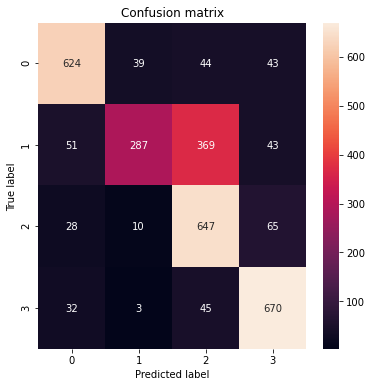

In [16]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	

## Naive Bayes

In [17]:
nb = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_train_tfidf)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

Accuracy: 0.6451833919517654
F1 score: 0.5229279152875014


### Testing

In [18]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = nb.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

Accuracy: 0.6175503493629264
F1 score: 0.4842607688159718


### Validation

In [19]:
y_pred_val = nb.predict(X_val_tfidf)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.354
F1 score: 0.2710472662054557


In [20]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.64      0.28      0.39       750
        hoax       1.00      0.00      0.01       750
  propaganda       0.29      1.00      0.45       750
    reliable       1.00      0.14      0.24       750

    accuracy                           0.35      3000
   macro avg       0.73      0.35      0.27      3000
weighted avg       0.73      0.35      0.27      3000



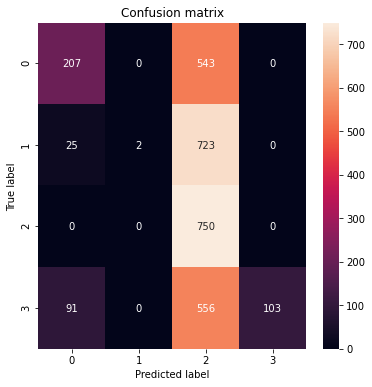

In [21]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	

## Linear Support Vector Machine

In [22]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=0, max_iter=5, tol=None).fit(X_train_tfidf, y_train)
y_pred = sgd.predict(X_train_tfidf)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

Accuracy: 0.8961083451331476
F1 score: 0.8939265637420594


### Testing

In [23]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = sgd.predict(X_test_tfidf)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

Accuracy: 0.8840937114673243
F1 score: 0.8816536468634609


### Validation

In [24]:
y_pred_val = nb.predict(X_val_tfidf)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.354
F1 score: 0.2710472662054557


In [25]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.64      0.28      0.39       750
        hoax       1.00      0.00      0.01       750
  propaganda       0.29      1.00      0.45       750
    reliable       1.00      0.14      0.24       750

    accuracy                           0.35      3000
   macro avg       0.73      0.35      0.27      3000
weighted avg       0.73      0.35      0.27      3000



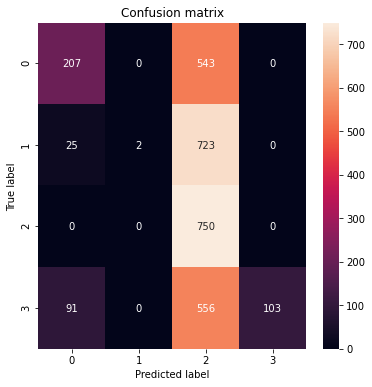

In [26]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	

## Random Forest

In [27]:
rfclf = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt').fit(X_train_tfidf, y_train)
y_pred = rfclf.predict(X_train_tfidf)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

Accuracy: 1.0
F1 score: 1.0


### Testing

In [28]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = rfclf.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

Accuracy: 0.8968351829017673
F1 score: 0.8930530806754715


### Validation

In [29]:
y_pred_val = rfclf.predict(X_val_tfidf)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.634
F1 score: 0.6014381279506406


## Word2Vec

In [30]:
train_df['text_clean'] = train_df['text'].apply(lambda x: preprocess(x))
train_df['clean_tokens'] = train_df['text_clean'].apply(lambda x: tokenize(x))
X = train_df['clean_tokens'].values
y = train_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=42)
X_train.shape, X_test.shape

((43786,), (4866,))

In [ ]:
# Train the word2vec model 
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=500,
                                   window=10)
words = set(w2v_model.wv.index_to_key)
print(words)
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])

In [ ]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(500, dtype=float))

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=200, solver='liblinear').fit(X_train_vect_avg, y_train)
y_pred = clf.predict(X_train_vect_avg)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

### Testing

In [ ]:
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(500, dtype=float))

In [ ]:
y_pred = clf.predict(X_test_vect_avg)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

### Validation

In [ ]:
test_df = pd.read_csv('raw_data/balancedtest.csv', header=None, names=['label', 'text'])
test_df['text_clean'] = test_df['text'].apply(lambda x: preprocess(x))
test_df['clean_tokens'] = test_df['text_clean'].apply(lambda x: tokenize(x))
X_val = test_df['clean_tokens'].values
y_val = test_df['label'].values

In [ ]:
X_val_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_val])
X_val_vect_avg = []
for v in X_val_vect:
    if v.size:
        X_val_vect_avg.append(v.mean(axis=0))
    else:
        X_val_vect_avg.append(np.zeros(500, dtype=float))

In [ ]:
y_pred_val = clf.predict(X_val_vect_avg)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

## gloVe

In [ ]:
embeddings_index = {}
f = open('raw_data/glove.840B.300d.txt', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
       coefs = np.asarray(values[1:], dtype='float32')
       embeddings_index[word] = coefs
    except ValueError:
       pass
f.close()

In [ ]:
def sent2vec(words):
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

### Testing

In [ ]:
xtrain_glove = [sent2vec(x) for x in tqdm(train_df['clean_tokens'])]
xtrain_glove = np.array(xtrain_glove)

In [ ]:
y = train_df['label']
clf = LogisticRegression(solver='sag').fit(xtrain_glove, y)
y_pred = clf.predict(xtrain_glove)
print(f"Accuracy: {accuracy_score(y, y_pred)}")
print(f"F1 score: {f1_score(y, y_pred, average='macro')}")

### Validation

In [ ]:
xtest_glove = [sent2vec(x) for x in tqdm(test_df['clean_tokens'])]
xtest_glove = np.array(xtest_glove)
y = test_df['label']
y_pred_val = clf.predict(xtest_glove)
print(f"Accuracy: {accuracy_score(y, y_pred_val)}")
print(f"F1 score: {f1_score(y, y_pred_val, average='macro')}")

## Feature Engineering

In [59]:
def contraction_count(text):
    count = 0
    for contract in contractions:
        count += re.subn(contract, '', text)[1]
    return count

def count_stopwords(text):  
    stopwords = nltk.corpus.stopwords.words("english")
    word_tokens = word_tokenize(text)
    stopwords_list = [w for w in word_tokens if w in stopwords]
    return len(stopwords_list)

def count_special_characters(text):
    count = 0
    for i in range(len(text)):
        if(not text[i].isalpha() and not text[i].isdigit()):
            count += 1
    return count

def count_uppercase(text):
    count = 0
    for i in range(len(text)):
        if(text[i].isupper()):
            count += 1
    return count

def count_lowercase(text):
    count = 0
    for i in range(len(text)):
        if(text[i].islower()):
            count += 1
    return count

def count_noun_verb_adverb_adjective(text):
    word_tokens = word_tokenize(text)
    word_tagged = pos_tag(word_tokens, tagset='universal')
    noun_count = 0
    verb_count = 0
    adv_count = 0
    adj_count = 0
    for pair in word_tagged:
        tag = pair[1]
        if tag == 'NOUN':
            noun_count += 1
        elif tag == 'VERB':
            verb_count += 1
        elif tag == 'ADV':
            adv_count += 1
        elif tag == 'ADJ':
            adj_count += 1
    return (noun_count, verb_count, adv_count, adj_count)

def count_syllable(text):
    words = word_tokenize(text)
    count = 0
    vowels = "aeiouy"
    for word in words:
        count += count_syllable_in_word(word, vowels)
    return count

def count_syllable_in_word(word, vowels):
    count = 0
    word = word.lower()
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

def get_gunning_fog_grade_index(text):
    # 0.4 [(words/sentences) + 100 (complex words/words)]
    # Complex words are those containing three or more syllables.
    sents = sent_tokenize(text)
    words = word_tokenize(text)
    num_sents = len(sents)
    num_words = len(words)
    num_complex_words = 0
    for word in words:
        if count_syllable_in_word(word, "aeiouy") >= 3:
            num_complex_words += 1
    return 0.4*(num_words/num_sents) + 100*(num_complex_words/num_words)
    
def get_dale_chall_readability_coleman_liau_index(text):
    words = word_tokenize(text)
    if (len(words) > 105):
        r = Readability(text)
        return (r.dale_chall(), r.coleman_liau())
    return (0, 0)

In [47]:
# Complexity Features
train_df['num_stopwords'] = train_df['text'].apply(lambda x: count_stopwords(x))
train_df['num_sentences'] = train_df['text'].apply(lambda x: len(str(x).split('.')))
train_df['num_contractions'] = train_df['text'].apply(lambda x: contraction_count(x))
train_df['num_special_characters'] = train_df['text'].apply(lambda x: count_special_characters(x))
train_df['num_uppercase'] = train_df['text'].apply(lambda x: count_uppercase(x))
train_df['num_lowercase'] = train_df['text'].apply(lambda x: count_lowercase(x))

# Stylometric Features
train_df['num_noun'] = train_df['text'].apply(lambda x: count_noun_verb_adverb_adjective(x)[0])
train_df['num_verb'] = train_df['text'].apply(lambda x: count_noun_verb_adverb_adjective(x)[1])
train_df['num_adverb'] = train_df['text'].apply(lambda x: count_noun_verb_adverb_adjective(x)[2])
train_df['num_adjective'] = train_df['text'].apply(lambda x: count_noun_verb_adverb_adjective(x)[3])
train_df['num_syllables'] = train_df['text'].apply(lambda x: count_syllable(x))

# Readability based evidence
train_df['gunning_fog_grade_index'] = train_df['text'].apply(lambda x: get_gunning_fog_grade_index(x))
train_df['dale_chall_readability'] = train_df['text'].apply(lambda x: get_dale_chall_readability_coleman_liau_index(x)[0])
train_df['coleman_liau_index'] = train_df['text'].apply(lambda x: get_dale_chall_readability_coleman_liau_index(x)[1])

# Psycho-linguistic features
train_df['polarity'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment[0])
train_df['subjectivity'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment[1])

NameError: name 'pair' is not defined

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE, smooth_idf=True, preprocessor=preprocess, tokenizer=tokenize, token_pattern=None)

In [ ]:
features = ['num_stopwords', 'num_sentences', 'num_contractions', 'num_special_characters',
            'num_uppercase', 'num_lowercase',
            'num_noun', 'num_verb', 'num_adverb', 'num_adjective', 'num_syllables',
            'gunning_fog_grade_index', 'dale_chall_readability', 'coleman_liau_index',
            'polarity', 'subjectivity', ]
y = train_df['label'].values
train_tfidf = tfidf_vectorizer.fit_transform(train_df['text'].values).toarray()
train_tfidf = pd.DataFrame(train_tfidf)
X_train_tfidf = pd.merge(train_tfidf, train_df[features], left_index=True, right_index=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size=TEST_SIZE, stratify=y, random_state=42)